In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import sys
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [4]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 9})
plt.rc('font', family='serif')

In [4]:
#load SNP annotation file (rows of Genotype Matrix) with gene annotation information
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl')

####################################################################################################################################################################################

## [1] This section uses the genotypes matrix to find *all* of the *minor alleles* for each SNP position

####################################################################################################################################################################################

### Load SNP genotype matrix and Annotation Files

In [12]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

#load SNP annotation file (rows of Genotype Matrix) with gene annotation information
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl')

#load Genotypes Matrix
genotypes_array =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy')

Columns of Genotype Matrix

In [13]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1


In [14]:
np.shape(isolate_annotation_DF)

(31428, 14)

Rows of Genotype Matrix

In [15]:
SNP_annotation_DF.head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,48,C,[T],Rv0001,47.0,Essential,dnaA
1,64,G,[C],Rv0001,63.0,Essential,dnaA
2,67,G,"[A, T]",Rv0001,66.0,Essential,dnaA
3,69,C,[T],Rv0001,68.0,Essential,dnaA
4,71,C,[T],Rv0001,70.0,Essential,dnaA


In [16]:
np.shape(SNP_annotation_DF)

(782565, 7)

Genotype Matrix

In [17]:
genotypes_array

array([[1, 1, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [1, 9, 9, ..., 1, 1, 1],
       [1, 9, 1, ..., 1, 1, 1],
       [1, 9, 1, ..., 1, 1, 1]], dtype=int8)

In [18]:
np.shape(genotypes_array)

(782565, 31428)

### Find the minor allele(s) for each SNP position from Genotypes Matrix

1. For each row of matrix (SNP) we will count the number of **0's**, **1's**, **2's** and **3's**.
1. For each SNP we will store a list of [number of 0's , number of 1's , number of 2's , number of 3's] to get a count for each **allele**

In [ ]:
genotypes_matrix_SNP_0_count = list( np.sum( genotypes_array == 0 , axis = 1 ) ) #A
genotypes_matrix_SNP_1_count = list( np.sum( genotypes_array == 1 , axis = 1 ) ) #C
genotypes_matrix_SNP_2_count = list( np.sum( genotypes_array == 2 , axis = 1 ) ) #G
genotypes_matrix_SNP_3_count = list( np.sum( genotypes_array == 3 , axis = 1 ) ) #T

#for each SNP position, count the number of 0 (A's), 1 (C's), 2 (G's), 3 (T's)
genotypes_matrix_allele_count = [ [zero_count , one_count , two_count , three_count] for zero_count , one_count , two_count , three_count in zip(genotypes_matrix_SNP_0_count , genotypes_matrix_SNP_1_count , genotypes_matrix_SNP_2_count , genotypes_matrix_SNP_3_count) ]

In [49]:
genotypes_matrix_allele_count[0:5]

[[0, 30295, 0, 5],
 [0, 5, 30507, 0],
 [2, 0, 30577, 1],
 [0, 30397, 0, 1],
 [0, 30394, 0, 152]]

In [50]:
np.shape(genotypes_matrix_allele_count)

(782565, 4)

#### Iterate through each SNP position and collect minor alleles

In [59]:
minor_alleles_per_SNP_pos = [ list(pd.Series(np.array(SNP_i_allele_count) , index = ['A' , 'C' , 'G' , 'T'])[np.array(SNP_i_allele_count) > 0].sort_values(ascending = True)[:-1].index) for SNP_i_allele_count in genotypes_matrix_allele_count ]

#add column with minor alleles to SNP annotation DF
SNP_annotation_DF.loc[: , 'minor'] = minor_alleles_per_SNP_pos

In [62]:
SNP_annotation_DF.head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name,minor
0,48,C,[T],Rv0001,47.0,Essential,dnaA,[T]
1,64,G,[C],Rv0001,63.0,Essential,dnaA,[C]
2,67,G,"[A, T]",Rv0001,66.0,Essential,dnaA,"[T, A]"
3,69,C,[T],Rv0001,68.0,Essential,dnaA,[T]
4,71,C,[T],Rv0001,70.0,Essential,dnaA,[T]


In [63]:
np.shape(SNP_annotation_DF)

(782565, 8)

#### Reformat SNP annotation DF so that each row corresponds to a minor allele

In [ ]:
SNP_index_list = [] #holds the index for SNP site in Genotypes Matrix
pos_list = []
ref_list = []
gene_id_list = []
gene_pos_list = []
gene_categ_list = []
gene_name_list = []
minor_allele_list = []

#iterate through each SNP position
for SNP_i in SNP_annotation_DF.index:
    
    #info for SNP
    SNP_i_annotation = SNP_annotation_DF.loc[SNP_i , :]
    
    #iterate through each minor allele called at this SNP site and store info
    for minor_allele_i in SNP_i_annotation.minor:
        
        SNP_index_list.append(SNP_i)
        pos_list.append(SNP_i_annotation.pos)
        ref_list.append(SNP_i_annotation.ref)
        gene_id_list.append(SNP_i_annotation.gene_id)
        gene_pos_list.append(SNP_i_annotation.gene_pos)
        gene_categ_list.append(SNP_i_annotation.gene_category)
        gene_name_list.append(SNP_i_annotation.gene_name)
        minor_allele_list.append(minor_allele_i)
    
SNP_minor_allele_annotation_DF = pd.DataFrame()
SNP_minor_allele_annotation_DF['SNP_i'] = SNP_index_list
SNP_minor_allele_annotation_DF['pos'] = pos_list
SNP_minor_allele_annotation_DF['ref'] = ref_list
SNP_minor_allele_annotation_DF['gene_id'] = gene_id_list
SNP_minor_allele_annotation_DF['gene_pos'] = gene_pos_list
SNP_minor_allele_annotation_DF['gene_category'] = gene_categ_list
SNP_minor_allele_annotation_DF['gene_name'] = gene_name_list
SNP_minor_allele_annotation_DF['minor'] = minor_allele_list

In [66]:
SNP_minor_allele_annotation_DF.head()

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor
0,0,48,C,Rv0001,47.0,Essential,dnaA,T
1,1,64,G,Rv0001,63.0,Essential,dnaA,C
2,2,67,G,Rv0001,66.0,Essential,dnaA,T
3,2,67,G,Rv0001,66.0,Essential,dnaA,A
4,3,69,C,Rv0001,68.0,Essential,dnaA,T


In [67]:
np.shape(SNP_minor_allele_annotation_DF)

(836901, 8)

Output dataframe as a pickle for downstream analysis

In [68]:
SNP_minor_allele_annotation_DF.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_minor_allele_annotation.pkl')

####################################################################################################################################################################################

## [2] Collect *homoplasy count* from SNPPar; prep for downstream analysis

####################################################################################################################################################################################

Load SNP *minor allele* annotation

In [4]:
SNP_minor_allele_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_minor_allele_annotation.pkl')

In [5]:
SNP_minor_allele_annotation_DF.head()

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor
0,0,48,C,Rv0001,47.0,Essential,dnaA,T
1,1,64,G,Rv0001,63.0,Essential,dnaA,C
2,2,67,G,Rv0001,66.0,Essential,dnaA,T
3,2,67,G,Rv0001,66.0,Essential,dnaA,A
4,3,69,C,Rv0001,68.0,Essential,dnaA,T


In [6]:
np.shape(SNP_minor_allele_annotation_DF)

(836901, 8)

### [2.1] Function to collect homoplasy count from SNPPar ouput *mutational event* TSV files

In [7]:
def SNPPar_homoplasy_count(global_lineage):

    #load mutation events DF from SNPPar
    mutation_events_DF = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/SNP_ancestral_reconstruction/lineage{0}/SNPPar_output/L{0}all_mutation_events_checked_against_seqs.tsv'.format(global_lineage) , sep = '\t')

    #drop unneccessary columns
    mutation_events_DF = mutation_events_DF.loc[: , ['Position','Ancestor_Node','Derived_Node','Ancestor_Call','Derived_Call']]

    #filter out events with amb/missing calls
    # > filter out mutations in which either the ancestor or derived allele is an 'N'
    # > the modification to the source code 'snppar.py' should already have taken care of this but in case a variant slipped through keep this code just in case
    ambiguous_mutations_filter = np.array([(ancestor_call == 'N') or (derived_call == 'N') for ancestor_call , derived_call in zip(mutation_events_DF.Ancestor_Call , mutation_events_DF.Derived_Call)])
    non_ambiguous_mutations_filter = [not ambiguous_mutation for ambiguous_mutation in ambiguous_mutations_filter]
    mutation_events_DF = mutation_events_DF[non_ambiguous_mutations_filter]

    #iterate through each SNP site/minor allele and count number of times SNP site (Reference Position) + (Minor Allele) matches a mutational event (Reference Position) + (Derived Allele) 
    # > create dictionary for mutational events - keys:Position+Derived_Call , values:Number of Mutational Events
    num_mutation_events_per_mutation = Counter([str(mut_i_pos) + '_' + mut_i_der_call for mut_i_pos, mut_i_der_call in zip(mutation_events_DF.loc[: , 'Position'] , mutation_events_DF.loc[: , 'Derived_Call'])])

    homoplasy_count = []
    for SNP_i_pos , SNP_i_minor_allele in zip(SNP_minor_allele_annotation_DF.pos , SNP_minor_allele_annotation_DF.minor):
        
        #count the number of mutational events that match this SNP position and minor allele
        SNP_i_minor_allele_count = num_mutation_events_per_mutation[str(SNP_i_pos) + '_' + SNP_i_minor_allele]
        homoplasy_count.append(SNP_i_minor_allele_count)
        
        #this modification is not necessary because Counter Dict kicks back '0' if key doesn't exist (instead of hitting a key error)
        '''
        #check to see if SNP_i minor allele was detected within this isolate group/global lineage
        if str(SNP_i_pos) + '_' + SNP_i_minor_allele in num_mutation_events_per_mutation.keys():
        
            #count the number of mutational events that match this SNP position and minor allele
            SNP_i_minor_allele_count = num_mutation_events_per_mutation[str(SNP_i_pos) + '_' + SNP_i_minor_allele]
            homoplasy_count.append(SNP_i_minor_allele_count)
        
        #particular SNP i - minor allele was not present within this group of isolates
        else:
            homoplasy_count.append(0)
        '''

    return homoplasy_count

### [2.2] Collect homoplasy count from SNPPar ouput for all global lineage (i.e. trees/isolate groups)

In [8]:
SNPPar_homoplasy_DF = SNP_minor_allele_annotation_DF.copy()

for global_lineage in ['1' , '2' , '3' , '4A' , '4B' , '4C' , '5' , '6']:
    
    SNPPar_homoplasy_DF.loc[: , global_lineage] = SNPPar_homoplasy_count(global_lineage)
    
#add homoplasy count across all lineages
SNPPar_homoplasy_DF.loc[: , 'total'] = SNPPar_homoplasy_DF.loc[: , ['1' , '2' , '3' , '4A' , '4B' , '4C' , '5' , '6']].sum(axis = 1)

/home/rv76/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (7,8,9,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/rv76/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [9]:
SNPPar_homoplasy_DF.head()

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
0,0,48,C,Rv0001,47.0,Essential,dnaA,T,0,1,0,0,0,0,0,0,1
1,1,64,G,Rv0001,63.0,Essential,dnaA,C,0,1,0,0,0,0,0,0,1
2,2,67,G,Rv0001,66.0,Essential,dnaA,T,1,0,0,0,0,0,0,0,1
3,2,67,G,Rv0001,66.0,Essential,dnaA,A,0,1,0,0,0,0,0,1,2
4,3,69,C,Rv0001,68.0,Essential,dnaA,T,0,0,0,1,0,0,0,0,1


In [10]:
np.shape(SNPPar_homoplasy_DF)

(836901, 17)

In [11]:
SNPPar_homoplasy_DF.sort_values(by = 'total' , ascending = False).head(n = 25)

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
419144,391656,2155168,C,Rv1908c,1279.0,Antibiotic Resistance,katG,G,203,408,297,306,310,179,8,6,1717
162233,150712,761155,C,Rv0667,1348.0,Antibiotic Resistance,rpoB,T,75,415,199,222,311,173,8,3,1406
166633,154766,781687,A,Rv0682,127.0,Antibiotic Resistance,rpsL,G,37,463,102,65,53,51,6,2,779
328332,306580,1673425,C,intergenic,NaN,None,None,T,168,202,62,111,114,87,5,3,752
792952,742888,4247429,A,Rv3795,915.0,Antibiotic Resistance,embB,G,32,406,67,76,99,60,2,1,743
293175,273547,1473246,A,Rvnr01,1400.0,None,None,G,5,331,32,71,68,53,0,0,560
2272,1981,7582,A,Rv0006,280.0,Antibiotic Resistance,gyrA,G,10,320,67,77,53,25,0,0,552
792956,742890,4247431,G,Rv3795,917.0,Antibiotic Resistance,embB,A,18,183,77,86,100,63,5,4,536
725256,679423,3883626,A,Rv3466,101.0,Non-Essential,Rv3466,G,0,123,59,49,143,25,6,0,405
725264,679431,3884906,A,Rv3467,942.0,Non-Essential,Rv3467,A,72,31,0,44,151,94,0,1,393


In [12]:
len(SNPPar_homoplasy_DF[SNPPar_homoplasy_DF.total >= 1].total) #Some mutations in genotypes matrix were not picked up by SNPPar, maybe due to splitting isolates into different trees

834981

### [2.3] Get functional annotation for all SNVs

Create a mutation key to join on with functional SNV annotation and set as index

In [13]:
mut_key_index = [str(SNP_i_pos) + '_' + SNP_i_minor_allele for SNP_i_pos, SNP_i_minor_allele in zip(SNPPar_homoplasy_DF.pos , SNPPar_homoplasy_DF.minor)]
SNPPar_homoplasy_DF['mut_key'] = mut_key_index
SNPPar_homoplasy_DF.set_index('mut_key', inplace = True, drop = True)

In [14]:
SNPPar_homoplasy_DF.head()

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
mut_key,,,,,,,,,,,,,,,,,
48_T,0,48,C,Rv0001,47.0,Essential,dnaA,T,0,1,0,0,0,0,0,0,1
64_C,1,64,G,Rv0001,63.0,Essential,dnaA,C,0,1,0,0,0,0,0,0,1
67_T,2,67,G,Rv0001,66.0,Essential,dnaA,T,1,0,0,0,0,0,0,0,1
67_A,2,67,G,Rv0001,66.0,Essential,dnaA,A,0,1,0,0,0,0,0,1,2
69_T,3,69,C,Rv0001,68.0,Essential,dnaA,T,0,0,0,1,0,0,0,0,1


Subset SNPPar homoplasy df to columns that we need (including **minor** allele)

In [15]:
SNPPar_homoplasy_DF = SNPPar_homoplasy_DF.loc[: , ['minor','gene_category','gene_name','1','2','3','4A','4B','4C','5','6','total']]

In [16]:
SNPPar_homoplasy_DF.head()

,minor,gene_category,gene_name,1,2,3,4A,4B,4C,5,6,total
mut_key,,,,,,,,,,,,
48_T,T,Essential,dnaA,0,1,0,0,0,0,0,0,1
64_C,C,Essential,dnaA,0,1,0,0,0,0,0,0,1
67_T,T,Essential,dnaA,1,0,0,0,0,0,0,0,1
67_A,A,Essential,dnaA,0,1,0,0,0,0,0,1,2
69_T,T,Essential,dnaA,0,0,0,1,0,0,0,0,1


Append **functional annotation** for SNPs

In [17]:
#load SNP annotation file (rows of Genotype Matrix) with gene annotation information
SNP_func_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_functional_annotation.pkl')

In [18]:
SNP_func_annotation_DF.head(n=2)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,SNP_type,AA_change
48_T,48,C,T,Essential,dnaA,Rv0001,48,S,V16V
64_C,64,G,C,Essential,dnaA,Rv0001,64,N,G22R


Subset functional annotation matrix to columns that we need

In [19]:
SNP_func_annotation_DF = SNP_func_annotation_DF.loc[: , ['pos','ref','alt','gene_id','gene_pos','SNP_type','AA_change']]

In [20]:
SNP_func_annotation_DF.head(n=10)

,pos,ref,alt,gene_id,gene_pos,SNP_type,AA_change
48_T,48,C,T,Rv0001,48,S,V16V
64_C,64,G,C,Rv0001,64,N,G22R
67_A,67,G,A,Rv0001,67,N,D23N
67_T,67,G,T,Rv0001,67,N,D23Y
69_T,69,C,T,Rv0001,69,S,D23D
71_T,71,C,T,Rv0001,71,N,P24L
75_A,75,G,A,Rv0001,75,S,K25K
78_G,78,T,G,Rv0001,78,S,V26V
79_C,79,G,C,Rv0001,79,N,D27H
81_T,81,C,T,Rv0001,81,S,D27D


In [21]:
np.shape(SNP_func_annotation_DF)

(844429, 7)

In some instances the **minor allele** is actually the **reference allele**, not the *alternate allele*. So we will create mutation keys with **H37Rv Ref Pos + Ref Allele** as well. Have to reverse the **AA_change** column.

In [22]:
SNP_func_annotation_DF_mod = SNP_func_annotation_DF.copy()

#create new mutation key index with reference alleles
mut_key_index = [str(SNP_i_pos) + '_' + SNP_i_ref_allele for SNP_i_pos, SNP_i_ref_allele in zip(SNP_func_annotation_DF.pos , SNP_func_annotation_DF.ref)]
SNP_func_annotation_DF_mod['mut_key'] = mut_key_index
SNP_func_annotation_DF_mod.set_index('mut_key', inplace = True, drop = True)

#reverse the order of AA change if Reference Allele is the minor allele and change in Non-Synonymous
AA_change_col = [AA_change[-1] + AA_change[1:-1] + AA_change[0] if (SNP_type == 'N') else AA_change for AA_change , SNP_type in zip(SNP_func_annotation_DF_mod.AA_change , SNP_func_annotation_DF_mod.SNP_type)]
SNP_func_annotation_DF_mod.loc[: , 'AA_change'] = AA_change_col

In [23]:
SNP_func_annotation_DF_mod.head(n=10)

,pos,ref,alt,gene_id,gene_pos,SNP_type,AA_change
mut_key,,,,,,,
48_C,48,C,T,Rv0001,48,S,V16V
64_G,64,G,C,Rv0001,64,N,R22G
67_G,67,G,A,Rv0001,67,N,N23D
67_G,67,G,T,Rv0001,67,N,Y23D
69_C,69,C,T,Rv0001,69,S,D23D
71_C,71,C,T,Rv0001,71,N,L24P
75_G,75,G,A,Rv0001,75,S,K25K
78_T,78,T,G,Rv0001,78,S,V26V
79_G,79,G,C,Rv0001,79,N,H27D


In [24]:
np.shape(SNP_func_annotation_DF_mod)

(844429, 7)

#### Append both SNP functional annotation DataFrames together

In [25]:
SNP_func_annotation_DF = SNP_func_annotation_DF.append(SNP_func_annotation_DF_mod)

In [26]:
np.shape(SNP_func_annotation_DF)

(1688858, 7)

In [27]:
SNP_func_annotation_DF.loc[:,'mut_key'] = SNP_func_annotation_DF.index

In [28]:
SNP_func_annotation_DF.head()

,pos,ref,alt,gene_id,gene_pos,SNP_type,AA_change,mut_key
48_T,48,C,T,Rv0001,48,S,V16V,48_T
64_C,64,G,C,Rv0001,64,N,G22R,64_C
67_A,67,G,A,Rv0001,67,N,D23N,67_A
67_T,67,G,T,Rv0001,67,N,D23Y,67_T
69_T,69,C,T,Rv0001,69,S,D23D,69_T


Remove duplicates by dropping rows with repeated index (mutation) keys

In [29]:
SNP_func_annotation_DF.drop_duplicates(subset = ['mut_key'] , keep='first', inplace = True)

In [30]:
np.shape(SNP_func_annotation_DF)

(1626994, 8)

#### JOIN (SNP functional annotation DF) to the (SNPPar homoplasy count DF) on the index of both DFs

In [31]:
SNPPar_homoplasy_DF = SNPPar_homoplasy_DF.join(SNP_func_annotation_DF , how = 'left')

In [32]:
SNPPar_homoplasy_DF.head(n = 5)

,minor,gene_category,gene_name,1,2,3,4A,4B,4C,5,6,total,pos,ref,alt,gene_id,gene_pos,SNP_type,AA_change,mut_key
mut_key,,,,,,,,,,,,,,,,,,,,
48_T,T,Essential,dnaA,0,1,0,0,0,0,0,0,1,48.0,C,T,Rv0001,48,S,V16V,48_T
64_C,C,Essential,dnaA,0,1,0,0,0,0,0,0,1,64.0,G,C,Rv0001,64,N,G22R,64_C
67_T,T,Essential,dnaA,1,0,0,0,0,0,0,0,1,67.0,G,T,Rv0001,67,N,D23Y,67_T
67_A,A,Essential,dnaA,0,1,0,0,0,0,0,1,2,67.0,G,A,Rv0001,67,N,D23N,67_A
69_T,T,Essential,dnaA,0,0,0,1,0,0,0,0,1,69.0,C,T,Rv0001,69,S,D23D,69_T


In [33]:
np.shape(SNPPar_homoplasy_DF)

(836901, 20)

#### A few *singleton* SNVs were not annotated as part of the original SNP annotation step, finish annotating these

In [34]:
SNVs_that_need_func_annotation_df = SNPPar_homoplasy_DF[[str(ref_pos) == 'nan' for ref_pos in SNPPar_homoplasy_DF.pos]]

In [35]:
SNVs_that_need_func_annotation_df.head()

,minor,gene_category,gene_name,1,2,3,4A,4B,4C,5,6,total,pos,ref,alt,gene_id,gene_pos,SNP_type,AA_change,mut_key
mut_key,,,,,,,,,,,,,,,,,,,,
112896_G,G,Essential,nrp,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500233_G,G,Non-Essential,mutT3,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525325_G,G,Non-Essential,pssA,0,1,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
774844_T,T,Essential,echA5,0,1,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1065778_G,G,Non-Essential,Rv0954,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
np.shape(SNVs_that_need_func_annotation_df)

(25, 20)

#### Cell to Annotate SNPs

In [37]:
# Important Packages
################################################################################################################################################################################################
import os
import pandas as pd
import numpy as np
import sys
import pickle

import Bio
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
################################################################################################################################################################################################


# Relevant Information for H37Rv sequence SNP functional annotation
################################################################################################################################################################################################
####### Collect all DNA and Amino Acid sequences corresponding to genes on H37Rv #######
#load reference genome and reference annotation
reference_genome = '/n/data1/hms/dbmi/farhat/bin/work-horse/bin/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

####### Function to translate coding DNA sequences ####### 
def translate(gene_id, sequence):

    #find which strand the gene is located on and translate
    strand = reference_genome_annotation.loc[gene_id, 'strand']
    if strand == '+':
        protein_sequence = sequence.translate(table="Bacterial", cds=False)
    elif strand == '-':
        protein_sequence = sequence.reverse_complement().translate(table="Bacterial", cds=False)

    return protein_sequence

####### Load in dictionaries for SNP annotation #######
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_gene_seq_records.pickle', 'rb') as handle:
    ref_gene_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_protein_seq_records.pickle', 'rb') as handle:
    ref_protein_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/pickled_files/dicts_for_SNP_annotation/H37Rv_coord_gene_mapping.pickle', 'rb') as handle:
    ReferencePosition_Gene_mapping = pickle.load(handle)
    
####### get Gene Categories #######
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')
gene_categories_dict = dict([gene_id , gene_category] for gene_id, gene_category in zip(list(gene_categories.gene_id) , list(gene_categories.Gene_Category)))

####### get Gene Symbols #######
gene_symbol_dict = dict([gene_id , gene_symbol] for gene_id, gene_symbol in zip(list(reference_genome_annotation.symbol.index) , list( reference_genome_annotation.symbol )))
################################################################################################################################################################################################


# Function to annotate Intergenic SNPs
################################################################################################################################################################################################
def find_flanking_genes_for_intergenic_region(intergenic_ref_pos): 

    #this function finds the genes flagging an intergenic region given a reference position

    #find gene immediately in the 5' direction
    for i in range(0 , 100000):

        #move toward 5' direction
        if ReferencePosition_Gene_mapping[intergenic_ref_pos - i] != []:

            gene_to_left = ReferencePosition_Gene_mapping[intergenic_ref_pos - i][0]
            break

    #find gene immediately in the 3' direction       
    for i in range(0 , 100000):

        #move toward 3' direction
        try:
            if ReferencePosition_Gene_mapping[intergenic_ref_pos + i] != []:

                gene_to_right = ReferencePosition_Gene_mapping[intergenic_ref_pos + i][0]
                break
        
        #KeyError means we have hit the 'end' of the chromosome, the intergenic region at then end of H37Rv in 5' > 3' orientation 
        #since TB chromosome is circular the gene to the 'right' is Rv0001    
        except KeyError:
            
            gene_to_right = 'Rv0001'
            break
    
    return gene_to_left + '_' + gene_to_right
################################################################################################################################################################################################


# Function to determine whether SNPs are Synonymous or Non-Synonymous; Returns gene coordinate, codon position, AA changes, Gene Category & Symbol
################################################################################################################################################################################################
def SNP_annotate(ref_seq_position , alt_allele_i):
    
    '''
    This function takes as input a reference position on H37Rv located within a 
    gene and an alternate allele and returns whether the base change 
    would correspond to a different Amino Acid sequence that results 
    from translating the DNA sequence into an AA sequence.
    
    '''
    gene_intergenic_id_list = []
    genomic_coord_list = []
    gene_category_list = []
    gene_symbol_list = []
    Syn_NSyn_list = []
    AA_change_list = []
    
    #get the Reference Allele from the complete H37Rv reference genome, indexing starts from 0
    ref_allele_i = reference_genome.seq[int(ref_seq_position) - 1] 
    
    #find the gene that SNP occurs on; check list corresponding to H37Rv coordinate to see if there are any genes associated with RefPosition, make sure not a tRNA
    if (len(ReferencePosition_Gene_mapping[ref_seq_position]) == 1): #and ('tRNA' not in reference_genome_annotation.loc[ReferencePosition_Gene_mapping[ref_seq_position][0], 'description']):   
        
        #retrieve gene that ReferencePosition is mapped to (i.e. SNP only corresponds to 1 gene)
        gene_intergenic_id = ReferencePosition_Gene_mapping[ref_seq_position][0]

        #find genomic coordinate of SNP relative to gene (subtract 1 since reference seq starts counting at 1)
        gene_relative_coord = (ref_seq_position - 1) - min( reference_genome_annotation.loc[gene_intergenic_id , 'chromStart'] , reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd'] )

        #find the genomic coordinate (relative to the gene, in the 5' to 3' direction)
        strand = reference_genome_annotation.loc[gene_intergenic_id, 'strand']
        if strand == '+':
             genomic_5_to_3_coord = (ref_seq_position) - reference_genome_annotation.loc[gene_intergenic_id , 'chromStart']

        elif strand == '-':
             genomic_5_to_3_coord = (reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd']) - (ref_seq_position-1)

        #find gene category (if one exists)
        try:
            gene_category_i = gene_categories_dict[gene_intergenic_id]
        except KeyError:
            gene_category_i = 'None'

        #find gene symbol (if one exists)
        try:
            gene_symbol_i = gene_symbol_dict[gene_intergenic_id]
        except KeyError:
            gene_symbol_i = 'None'

        #alternate allele is an actual base
        if alt_allele_i in ['A','C','G','T']:

            #translate into protein sequence with the SNP in place if not InDel or intergenic region
            SNP_change = alt_allele_i

            #ALTERNATE allele (is it Syn or NSyn?)
            #get sequence from dictionary of sequences (and convert to mutable object)
            test_gene_sequence = ref_gene_sequences_records[gene_intergenic_id].seq.tomutable()

            #change reference gene sequence by the SNP in the query sequence
            test_gene_sequence[int(gene_relative_coord)] = SNP_change

            #convert back immutable object
            test_gene_sequence = test_gene_sequence.toseq()

            #translate sequence into amino acid seq
            test_protein_sequence = translate(gene_intergenic_id , test_gene_sequence)

            #store the H37Rv AA seq to compare against
            H37Rv_AA_sequence = ref_protein_sequences_records[gene_intergenic_id].seq

            #get the codon number where the SNP occurs within
            ## take the genomic coordinate (relative to the gene, in the 5' to 3' direction), divide by 3, then take the ceiling of this number (will be fraction if SNP occurs in 1st or 2nd position on codon)
            strand = reference_genome_annotation.loc[gene_intergenic_id, 'strand']
            if strand == '+':
                 genomic_5_to_3_coord = (ref_seq_position) - reference_genome_annotation.loc[gene_intergenic_id , 'chromStart']

            elif strand == '-':
                 genomic_5_to_3_coord = (reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd']) - (ref_seq_position-1)

            codon_coord = int(np.ceil( float( genomic_5_to_3_coord) / 3.0 ))

            #################################################################
            #compare to AA seq of original gene
            if test_protein_sequence == H37Rv_AA_sequence:

                try:
                    SNP_type = 'S'
                    AA_change = H37Rv_AA_sequence[codon_coord-1] + str(codon_coord) + test_protein_sequence[codon_coord-1] #get the AA before & after
                
                except IndexError:
                    SNP_type = 'None'
                    AA_change = 'None'
            else:
                
                try:
                    SNP_type = 'N'
                    AA_change = H37Rv_AA_sequence[codon_coord-1] + str(codon_coord) + test_protein_sequence[codon_coord-1] #get the AA before & after
                    
                except IndexError:
                    SNP_type = 'None'
                    AA_change = 'None'
            #################################################################

        #alternate allele is a dummy (Base Call completely supports the Reference Allele)       
        else:

            SNP_type = 'None'
            AA_change = 'None'

        #store relevant info in lists    
        gene_intergenic_id_list.append(gene_intergenic_id)
        genomic_coord_list.append(genomic_5_to_3_coord)
        gene_category_list.append(gene_category_i)
        gene_symbol_list.append(gene_symbol_i)
        Syn_NSyn_list.append(SNP_type)
        AA_change_list.append(AA_change)
    
    #if no gene in H37Rv corresponds to the Reference Position for SNP, then SNP must be intergenic
    else:
        
        gene_intergenic_id = find_flanking_genes_for_intergenic_region(ref_seq_position)
        genomic_5_to_3_coord = 'None'
        gene_category_i = 'None'
        gene_symbol_i = 'None'
        SNP_type = 'I'
        AA_change = 'None'
        
        #store relevant info in lists    
        gene_intergenic_id_list.append(gene_intergenic_id)
        genomic_coord_list.append(genomic_5_to_3_coord)
        gene_category_list.append(gene_category_i)
        gene_symbol_list.append(gene_symbol_i)
        Syn_NSyn_list.append(SNP_type)
        AA_change_list.append(AA_change)
    
    #if there is only a single gene associated with this SNP, just return the individual elememts
    if len(gene_intergenic_id_list) == 1:
        return [ref_allele_i , gene_intergenic_id , genomic_5_to_3_coord , gene_category_i , gene_symbol_i , SNP_type , AA_change]
    
    #else if there are two genes associated with this SNP, return elements for each SNP annotation in a list
    elif len(gene_intergenic_id_list) > 1:
        return [ref_allele_i , gene_intergenic_id_list , genomic_coord_list , gene_category_list , gene_symbol_list , Syn_NSyn_list , AA_change_list]
################################################################################################################################################################################################

#### Iterate through each Reference Position - Alternate Allele pair with missing annotation, get relevant annotation & store in SNP homoplasy df

In [38]:
for SNP_i in SNVs_that_need_func_annotation_df.index:
    
    #get the reference position & alternate allele from index key
    ref_pos_i , alt_allele_i = SNP_i.split('_')
    
    #get functional annotation for SNP
    ref_allele_i , gene_intergenic_id_i , gene_pos_i , gene_category_i , gene_symbol_i , SNP_type_i , AA_change_i = SNP_annotate(int(ref_pos_i) , alt_allele_i)
    
    #store functional annotation SNP df
    SNPPar_homoplasy_DF.loc[SNP_i , ['pos', 'ref', 'alt', 'gene_id', 'gene_pos', 'SNP_type', 'AA_change', 'mut_key']] = [float(ref_pos_i), ref_allele_i, alt_allele_i, gene_intergenic_id_i, gene_pos_i, SNP_type_i, AA_change_i, SNP_i]

In [39]:
SNPPar_homoplasy_DF.head()

,minor,gene_category,gene_name,1,2,3,4A,4B,4C,5,6,total,pos,ref,alt,gene_id,gene_pos,SNP_type,AA_change,mut_key
mut_key,,,,,,,,,,,,,,,,,,,,
48_T,T,Essential,dnaA,0,1,0,0,0,0,0,0,1,48.0,C,T,Rv0001,48,S,V16V,48_T
64_C,C,Essential,dnaA,0,1,0,0,0,0,0,0,1,64.0,G,C,Rv0001,64,N,G22R,64_C
67_T,T,Essential,dnaA,1,0,0,0,0,0,0,0,1,67.0,G,T,Rv0001,67,N,D23Y,67_T
67_A,A,Essential,dnaA,0,1,0,0,0,0,0,1,2,67.0,G,A,Rv0001,67,N,D23N,67_A
69_T,T,Essential,dnaA,0,0,0,1,0,0,0,0,1,69.0,C,T,Rv0001,69,S,D23D,69_T


Sort in descending order of homoplasy count (keep original indexing for comparing to **TopDis** counts later on)

In [40]:
SNPPar_homoplasy_DF_orig_ordering = SNPPar_homoplasy_DF.copy()
SNPPar_homoplasy_DF.sort_values(by = 'total' , ascending = False , inplace = True)

In [41]:
SNPPar_homoplasy_DF.head(n=5)

,minor,gene_category,gene_name,1,2,3,4A,4B,4C,5,6,total,pos,ref,alt,gene_id,gene_pos,SNP_type,AA_change,mut_key
mut_key,,,,,,,,,,,,,,,,,,,,
2155168_G,G,Antibiotic Resistance,katG,203,408,297,306,310,179,8,6,1717,2155168.0,C,G,Rv1908c,944,N,S315T,2155168_G
761155_T,T,Antibiotic Resistance,rpoB,75,415,199,222,311,173,8,3,1406,761155.0,C,T,Rv0667,1349,N,S450L,761155_T
781687_G,G,Antibiotic Resistance,rpsL,37,463,102,65,53,51,6,2,779,781687.0,A,G,Rv0682,128,N,K43R,781687_G
1673425_T,T,None,None,168,202,62,111,114,87,5,3,752,1673425.0,C,T,Rv1482c_Rv1483,None,I,None,1673425_T
4247429_G,G,Antibiotic Resistance,embB,32,406,67,76,99,60,2,1,743,4247429.0,A,G,Rv3795,916,N,M306V,4247429_G


Re-arrange columns of dataframe

In [42]:
SNPPar_homoplasy_DF = SNPPar_homoplasy_DF.loc[: , ['pos','ref','alt','minor','gene_id','gene_name','gene_pos','gene_category','SNP_type','AA_change','1','2','3','4A','4B','4C','5','6','total']]

In [43]:
SNPPar_homoplasy_DF.head(n=20)

,pos,ref,alt,minor,gene_id,gene_name,gene_pos,gene_category,SNP_type,AA_change,1,2,3,4A,4B,4C,5,6,total
mut_key,,,,,,,,,,,,,,,,,,,
2155168_G,2155168.0,C,G,G,Rv1908c,katG,944,Antibiotic Resistance,N,S315T,203,408,297,306,310,179,8,6,1717
761155_T,761155.0,C,T,T,Rv0667,rpoB,1349,Antibiotic Resistance,N,S450L,75,415,199,222,311,173,8,3,1406
781687_G,781687.0,A,G,G,Rv0682,rpsL,128,Antibiotic Resistance,N,K43R,37,463,102,65,53,51,6,2,779
1673425_T,1673425.0,C,T,T,Rv1482c_Rv1483,None,None,None,I,None,168,202,62,111,114,87,5,3,752
4247429_G,4247429.0,A,G,G,Rv3795,embB,916,Antibiotic Resistance,N,M306V,32,406,67,76,99,60,2,1,743
1473246_G,1473246.0,A,G,G,Rvnr01,None,1401,None,S,S467S,5,331,32,71,68,53,0,0,560
7582_G,7582.0,A,G,G,Rv0006,gyrA,281,Antibiotic Resistance,N,D94G,10,320,67,77,53,25,0,0,552
4247431_A,4247431.0,G,A,A,Rv3795,embB,918,Antibiotic Resistance,N,M306I,18,183,77,86,100,63,5,4,536
3883626_G,3883626.0,A,G,G,Rv3466,Rv3466,102,Non-Essential,S,P34P,0,123,59,49,143,25,6,0,405


### [2.4] For each SNV get better *gene names* from Mycobrowser annotation

Parse through Mycobrowser (tuberculist) to collect function & gene names

In [44]:
mycobrowser_table = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/complete_genomes/H37Rv/Mycobrowser_Release3/Mycobacterium_tuberculosis_H37Rv_txt_v3.txt' , sep = '\t')

#drop unnecessary columns
mycobrowser_table = mycobrowser_table.loc[: , ['Refseq_ID' , 'Feature' , 'Start' , 'Stop', 'Score' , 'Strand' , 'Frame' , 'Locus' , 'Name' , 'Function' , 'Product' , 'Comments' , 'UniProt_AC' , 'Is_Pseudogene' , 'Functional_Category']]

#organize by Start Ref Position
mycobrowser_table.sort_values(by = ['Start'] , inplace = True)

#reset index
mycobrowser_table.reset_index(inplace = True , drop = True)

#### create mapping from *gene/intergenic* id to gene symbols/names

Get a list of genes/intergenic regions listed in df

In [45]:
gene_intergenic_region_IDs_list = list(set(SNPPar_homoplasy_DF.gene_id))
gene_intergenic_region_IDs_list = [x for x in gene_intergenic_region_IDs_list if str(x) != 'nan'] #remove nan values

In [46]:
len(gene_intergenic_region_IDs_list)

6745

Use mycobrowser table to get gene names/symbols for all gene/intergenic IDs

In [47]:
gene_names_list = []
for gene_intergenic_ID in gene_intergenic_region_IDs_list:
    
    if '_' not in gene_intergenic_ID:
        
        try:
            gene_names_list.append( mycobrowser_table[mycobrowser_table.Locus == gene_intergenic_ID].Name.values[0] )
        except IndexError:
            gene_names_list.append( gene_intergenic_ID )
        
    else:
        
        try:
            gene_name_1 = mycobrowser_table[mycobrowser_table.Locus == gene_intergenic_ID.split('_')[0]].Name.values[0]
        except IndexError:    
            gene_name_1 = gene_intergenic_ID.split('_')[0]
            
        try:
            gene_name_2 = mycobrowser_table[mycobrowser_table.Locus == gene_intergenic_ID.split('_')[1]].Name.values[0]
        except IndexError:    
            gene_name_2 = gene_intergenic_ID.split('_')[1]
        
        gene_names_list.append( gene_name_1 + '_' + gene_name_2 )

In [48]:
len(gene_names_list)

6745

Create dataframe for gene ids - gene names from Mycobrowser Annotation Table

In [49]:
gene_intergenic_region_ID_name_dict = dict([[gene_intergenic_id, gene_name] for gene_intergenic_id, gene_name in zip(gene_intergenic_region_IDs_list, gene_names_list)]) #convert to dictionary
gene_intergenic_region_ID_name_series = pd.Series(gene_intergenic_region_ID_name_dict, name = 'gene_name') #convert to series
gene_intergenic_region_ID_name_df = pd.DataFrame(gene_intergenic_region_ID_name_series) #convert to dataframe for merging
gene_intergenic_region_ID_name_df.loc[: , 'gene_id'] = gene_intergenic_region_ID_name_df.index #make gene_id a column

In [50]:
gene_intergenic_region_ID_name_df.head()

,gene_name,gene_id
Rv0001,dnaA,Rv0001
Rv0001_Rv0002,dnaA_dnaN,Rv0001_Rv0002
Rv0002,dnaN,Rv0002
Rv0002_Rv0003,dnaN_recF,Rv0002_Rv0003
Rv0003,recF,Rv0003


#### manually change gene ID/name mapping for some RNA loci

In [51]:
gene_intergenic_region_ID_name_df[[('Rvnr' in gene_id) for gene_id in gene_intergenic_region_ID_name_df.gene_id]]

,gene_name,gene_id
Rv1315_Rvnr01,murA_Rvnr01,Rv1315_Rvnr01
Rvnr01,Rvnr01,Rvnr01
Rvnr01_Rvnr02,Rvnr01_Rvnr02,Rvnr01_Rvnr02
Rvnr02,Rvnr02,Rvnr02
Rvnr02_Rvnr03,Rvnr02_Rvnr03,Rvnr02_Rvnr03
Rvnr03,Rvnr03,Rvnr03
Rvnr03_Rv1316c,Rvnr03_ogt,Rvnr03_Rv1316c


In [52]:
gene_intergenic_region_ID_name_df.loc['Rv1315_Rvnr01','gene_name'] = 'murA_rrs'
gene_intergenic_region_ID_name_df.loc['Rvnr01','gene_name'] = 'rrs'
gene_intergenic_region_ID_name_df.loc['Rvnr01_Rvnr02','gene_name'] = 'rrs_rrl'
gene_intergenic_region_ID_name_df.loc['Rvnr02','gene_name'] = 'rrl'
gene_intergenic_region_ID_name_df.loc['Rvnr02_Rvnr03','gene_name'] = 'rrl_rrf'
gene_intergenic_region_ID_name_df.loc['Rvnr03','gene_name'] = 'rrf'
gene_intergenic_region_ID_name_df.loc['Rvnr03_Rv1316c','gene_name'] = 'rrf_ogt'

In [53]:
gene_intergenic_region_ID_name_df[[('Rvnr' in gene_id) for gene_id in gene_intergenic_region_ID_name_df.gene_id]]

,gene_name,gene_id
Rv1315_Rvnr01,murA_rrs,Rv1315_Rvnr01
Rvnr01,rrs,Rvnr01
Rvnr01_Rvnr02,rrs_rrl,Rvnr01_Rvnr02
Rvnr02,rrl,Rvnr02
Rvnr02_Rvnr03,rrl_rrf,Rvnr02_Rvnr03
Rvnr03,rrf,Rvnr03
Rvnr03_Rv1316c,rrf_ogt,Rvnr03_Rv1316c


In [54]:
gene_intergenic_region_ID_name_df.reset_index(inplace = True , drop = True) #reset index

In [55]:
gene_intergenic_region_ID_name_df.head()

,gene_name,gene_id
0,dnaA,Rv0001
1,dnaA_dnaN,Rv0001_Rv0002
2,dnaN,Rv0002
3,dnaN_recF,Rv0002_Rv0003
4,recF,Rv0003


#### drop *gene name* column from original variant dataframe and merge with *gene name* dataframe created from mycobrowser annotation

In [56]:
SNPPar_homoplasy_DF.drop(['gene_name'] , axis = 1 , inplace = True)
SNPPar_homoplasy_DF = pd.merge(SNPPar_homoplasy_DF, gene_intergenic_region_ID_name_df, on = 'gene_id' , how = 'left')

In [57]:
SNPPar_homoplasy_DF.head(n=10)

,pos,ref,alt,minor,gene_id,gene_pos,gene_category,SNP_type,AA_change,1,2,3,4A,4B,4C,5,6,total,gene_name
0,2155168.0,C,G,G,Rv1908c,944,Antibiotic Resistance,N,S315T,203,408,297,306,310,179,8,6,1717,katG
1,761155.0,C,T,T,Rv0667,1349,Antibiotic Resistance,N,S450L,75,415,199,222,311,173,8,3,1406,rpoB
2,781687.0,A,G,G,Rv0682,128,Antibiotic Resistance,N,K43R,37,463,102,65,53,51,6,2,779,rpsL
3,1673425.0,C,T,T,Rv1482c_Rv1483,None,None,I,None,168,202,62,111,114,87,5,3,752,Rv1482c_fabG1
4,4247429.0,A,G,G,Rv3795,916,Antibiotic Resistance,N,M306V,32,406,67,76,99,60,2,1,743,embB
5,1473246.0,A,G,G,Rvnr01,1401,None,S,S467S,5,331,32,71,68,53,0,0,560,rrs
6,7582.0,A,G,G,Rv0006,281,Antibiotic Resistance,N,D94G,10,320,67,77,53,25,0,0,552,gyrA
7,4247431.0,G,A,A,Rv3795,918,Antibiotic Resistance,N,M306I,18,183,77,86,100,63,5,4,536,embB
8,3883626.0,A,G,G,Rv3466,102,Non-Essential,S,P34P,0,123,59,49,143,25,6,0,405,Rv3466
9,3884906.0,A,G,A,Rv3467,943,Non-Essential,N,E315K,72,31,0,44,151,94,0,1,393,Rv3467


### [2.5] For each SNV check whether the SNV is located within a non-coding RNA region

#### H37Rv locations for the non-coding RNA regions (to exclude from protein coding sequences) & function to check if given Ref Position is loated within RNA region

In [58]:
#subset table to the non-coding RNA regions
mycobrowser_table_RNA = mycobrowser_table[[('RNA' in gene_feature) for gene_feature in mycobrowser_table.Feature]]

#subset table to protein coding regions
mycobrowser_table_CDS = mycobrowser_table[mycobrowser_table.Feature == 'CDS']
CDS_locus_tags = set(list(mycobrowser_table_CDS.Locus))

#get noncoding regions (H37Rv start/stop coordinates) as a list
RNA_regions = [[min(RNA_start , RNA_end) , max(RNA_start , RNA_end)] for RNA_start, RNA_end in zip(mycobrowser_table_RNA.Start, mycobrowser_table_RNA.Stop)]

def check_pos_in_RNA(ref_pos, locus_tag):
    '''
    This function checks to see if an H37Rv Reference Position 
    is located within an RNA region of the genome.
    
    First checks whether the H37Rv locus tag is protein coding
    CDS region. If not, then checks if located in an RNA region.
    
    Note - Reference Positions that are located in overlapping 
    CDS/RNA regions will by default be classified as belonging to 
    the CDS region.
    '''
    
    ref_pos_in_RNA = False #default to False (ref pos not in noncoding RNA region)
    
    #locus tag does not belong to CDS region, check if ref pos is located in RNA
    if locus_tag not in CDS_locus_tags:
    
        for RNA_region_i in RNA_regions:

            if (ref_pos >= RNA_region_i[0]) and (ref_pos <= RNA_region_i[1]):

                ref_pos_in_RNA = True
                break
                
    return ref_pos_in_RNA

#### Iterate through each SNV allele and check to see if Ref Position is located within ncRNA region

In [59]:
for SNV_i , ref_pos_i , gene_id_i in zip(SNPPar_homoplasy_DF.index , SNPPar_homoplasy_DF.pos , SNPPar_homoplasy_DF.gene_id):
    
    #check to see if SNV is actually located in ncRNA region & not in CDS region, if TRUE change annotation
    if check_pos_in_RNA(ref_pos_i, gene_id_i) == True:
        
        SNPPar_homoplasy_DF.loc[SNV_i , 'SNP_type'] = 'R'
        SNPPar_homoplasy_DF.loc[SNV_i , 'AA_change'] = 'None'

In [60]:
SNPPar_homoplasy_DF.head(n=10)

,pos,ref,alt,minor,gene_id,gene_pos,gene_category,SNP_type,AA_change,1,2,3,4A,4B,4C,5,6,total,gene_name
0,2155168.0,C,G,G,Rv1908c,944,Antibiotic Resistance,N,S315T,203,408,297,306,310,179,8,6,1717,katG
1,761155.0,C,T,T,Rv0667,1349,Antibiotic Resistance,N,S450L,75,415,199,222,311,173,8,3,1406,rpoB
2,781687.0,A,G,G,Rv0682,128,Antibiotic Resistance,N,K43R,37,463,102,65,53,51,6,2,779,rpsL
3,1673425.0,C,T,T,Rv1482c_Rv1483,None,None,I,None,168,202,62,111,114,87,5,3,752,Rv1482c_fabG1
4,4247429.0,A,G,G,Rv3795,916,Antibiotic Resistance,N,M306V,32,406,67,76,99,60,2,1,743,embB
5,1473246.0,A,G,G,Rvnr01,1401,None,R,None,5,331,32,71,68,53,0,0,560,rrs
6,7582.0,A,G,G,Rv0006,281,Antibiotic Resistance,N,D94G,10,320,67,77,53,25,0,0,552,gyrA
7,4247431.0,G,A,A,Rv3795,918,Antibiotic Resistance,N,M306I,18,183,77,86,100,63,5,4,536,embB
8,3883626.0,A,G,G,Rv3466,102,Non-Essential,S,P34P,0,123,59,49,143,25,6,0,405,Rv3466
9,3884906.0,A,G,A,Rv3467,943,Non-Essential,N,E315K,72,31,0,44,151,94,0,1,393,Rv3467


### [2.6] For each SNV find the number of isolates (N = 31,428) with the *minor* allele

#### Load SNP genotype matrix and Annotation Files

In [5]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

#load SNP annotation file (rows of Genotype Matrix) with gene annotation information
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl')

#load Genotypes Matrix
genotypes_array =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy')

In [6]:
allele_code_map_dict = {'A':0 , 'C':1 , 'G':2 , 'T':3}
allele_code_map_dict_r = {0:'A' , 1:'C' , 2:'G' , 3:'T'}

In [7]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1


In [8]:
np.shape(isolate_annotation_DF)

(31428, 14)

In [9]:
SNP_annotation_DF.head()

,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name
0,48,C,[T],Rv0001,47.0,Essential,dnaA
1,64,G,[C],Rv0001,63.0,Essential,dnaA
2,67,G,"[A, T]",Rv0001,66.0,Essential,dnaA
3,69,C,[T],Rv0001,68.0,Essential,dnaA
4,71,C,[T],Rv0001,70.0,Essential,dnaA


In [10]:
np.shape(SNP_annotation_DF)

(782565, 7)

In [11]:
np.shape(genotypes_array)

(782565, 31428)

In [ ]:
SNPPar_homoplasy_DF.head()

In [69]:
num_isolates_with_SNV_i_list = []

for pos_i, minor_allele_i in zip(SNPPar_homoplasy_DF.pos , SNPPar_homoplasy_DF.minor):
    
    #Get Genotypes for SNP
    #get row index of genotypes matrix that corresponds to this row
    SNP_site_row_index = SNP_annotation_DF[SNP_annotation_DF.pos == pos_i].index.values[0]
    
    #get the genotypes for all isolates
    SNP_site_genotypes = genotypes_array[SNP_site_row_index , :]
    
    #construct a boolean array that is TRUE if isolate's genotype matches the alternate allele and FALSE otherwise
    isolate_minor_allele_match_bool = SNP_site_genotypes == allele_code_map_dict[minor_allele_i]
    
    num_isolates_with_SNV_i_list.append(np.sum(isolate_minor_allele_match_bool))
    
#append as columns in the Homoplasic INDEL DataFrame
SNPPar_homoplasy_DF.loc[: , 'num_isolates_alt'] = num_isolates_with_SNV_i_list

### [2.6A] For each SNV find the number of isolates (N = 31,428) with the *alternate* allele for ESX-related genes for Oren & breakdown by lineage (can skip for other analyses)

#### Load SNP genotype matrix and Annotation Files

In [5]:
#load isolate annotation file (columns of Genotype Matrix)
isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

#load SNP annotation file (rows of Genotype Matrix) with gene annotation information
SNP_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl')

#load Genotypes Matrix
genotypes_array =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy')

In [6]:
allele_code_map_dict = {'A':0 , 'C':1 , 'G':2 , 'T':3}
allele_code_map_dict_r = {0:'A' , 1:'C' , 2:'G' , 3:'T'}

In [30]:
ESX_SNPs_for_Oren_df = pd.read_excel('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Tzfadia Lab Collab/ESX1_genes_homoplasy_SNPs_for_Oren 1.xlsx')

In [31]:
ESX_SNPs_for_Oren_df.head()

,pos,ref,alt,gene_id,gene_pos,SNP_type,AA_change,Lineage 1,Lineage 2,Lineage 3,Lineage 4A,Lineage 4B,Lineage 4C,Lineage 5,Lineage 6,total,gene_name,num_isolates_alt_allele
0,791084,G,T,Rv0691c,583,S,R195R,0,0,0,1,0,0,0,0,1,Rv0691c,6
1,791088,C,G,Rv0691c,579,S,L193L,0,0,0,0,1,0,0,0,1,Rv0691c,4
2,791090,G,T,Rv0691c,577,N,L193M,0,1,0,0,0,0,0,0,1,Rv0691c,1
3,791094,G,A,Rv0691c,573,S,A191A,1,0,0,0,0,0,0,0,1,Rv0691c,6
4,791097,G,A,Rv0691c,570,S,G190G,0,0,0,0,0,1,0,0,1,Rv0691c,1


In [29]:
from collections import Counter

In [32]:
num_isolates_with_SNV_i_list = []
lin_1_alt_allele = []
lin_2_alt_allele = []
lin_3_alt_allele = []
lin_4_alt_allele = []
lin_5_alt_allele = []
lin_6_alt_allele = []

for pos_i, alt_allele_i in zip(ESX_SNPs_for_Oren_df.pos , ESX_SNPs_for_Oren_df.alt):
    
    # Get Genotypes for SNP
    # get row index of genotypes matrix that corresponds to this row
    SNP_site_row_index = SNP_annotation_DF[SNP_annotation_DF.pos == pos_i].index.values[0]
    
    # get the genotypes for all isolates
    SNP_site_genotypes = genotypes_array[SNP_site_row_index , :]
    
    # construct a boolean array that is TRUE if isolate's genotype matches the alternate allele and FALSE otherwise
    isolate_alternate_allele_match_bool = SNP_site_genotypes == allele_code_map_dict[alt_allele_i]
    
    num_isolates_with_SNV_i_list.append(np.sum(isolate_alternate_allele_match_bool))
    
    # store the number of isolates broken down by lineage
    lineage_count_alt_allele_dict = Counter(isolate_annotation_DF[isolate_alternate_allele_match_bool].lineage_1)
    
    if '1' in lineage_count_alt_allele_dict.keys():
        lin_1_alt_allele.append(lineage_count_alt_allele_dict['1'])
    else:
        lin_1_alt_allele.append(0)
        
    if '2' in lineage_count_alt_allele_dict.keys():
        lin_2_alt_allele.append(lineage_count_alt_allele_dict['2'])
    else:
        lin_2_alt_allele.append(0)
        
    if '3' in lineage_count_alt_allele_dict.keys():
        lin_3_alt_allele.append(lineage_count_alt_allele_dict['3'])
    else:
        lin_3_alt_allele.append(0)
        
    if '4' in lineage_count_alt_allele_dict.keys():
        lin_4_alt_allele.append(lineage_count_alt_allele_dict['4'])
    else:
        lin_4_alt_allele.append(0)
        
    if '5' in lineage_count_alt_allele_dict.keys():
        lin_5_alt_allele.append(lineage_count_alt_allele_dict['5'])
    else:
        lin_5_alt_allele.append(0)
        
    if '6' in lineage_count_alt_allele_dict.keys():
        lin_6_alt_allele.append(lineage_count_alt_allele_dict['6'])
    else:
        lin_6_alt_allele.append(0)
    
#append as columns in the Homoplasic INDEL DataFrame
ESX_SNPs_for_Oren_df.loc[: , 'num_isolates_alt_1'] = lin_1_alt_allele
ESX_SNPs_for_Oren_df.loc[: , 'num_isolates_alt_2'] = lin_2_alt_allele
ESX_SNPs_for_Oren_df.loc[: , 'num_isolates_alt_3'] = lin_3_alt_allele
ESX_SNPs_for_Oren_df.loc[: , 'num_isolates_alt_4'] = lin_4_alt_allele
ESX_SNPs_for_Oren_df.loc[: , 'num_isolates_alt_5'] = lin_5_alt_allele
ESX_SNPs_for_Oren_df.loc[: , 'num_isolates_alt_6'] = lin_6_alt_allele

In [33]:
ESX_SNPs_for_Oren_df.head()

,pos,ref,alt,gene_id,gene_pos,SNP_type,AA_change,Lineage 1,Lineage 2,Lineage 3,...,Lineage 6,total,gene_name,num_isolates_alt_allele,num_isolates_alt_1,num_isolates_alt_2,num_isolates_alt_3,num_isolates_alt_4,num_isolates_alt_5,num_isolates_alt_6
0,791084,G,T,Rv0691c,583,S,R195R,0,0,0,...,0,1,Rv0691c,6,0,0,0,6,0,0
1,791088,C,G,Rv0691c,579,S,L193L,0,0,0,...,0,1,Rv0691c,4,0,0,0,4,0,0
2,791090,G,T,Rv0691c,577,N,L193M,0,1,0,...,0,1,Rv0691c,1,0,1,0,0,0,0
3,791094,G,A,Rv0691c,573,S,A191A,1,0,0,...,0,1,Rv0691c,6,6,0,0,0,0,0
4,791097,G,A,Rv0691c,570,S,G190G,0,0,0,...,0,1,Rv0691c,1,0,0,0,1,0,0


In [35]:
ESX_SNPs_for_Oren_df.shape

(9043, 24)

In [41]:
ESX_SNPs_for_Oren_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Tzfadia Lab Collab/ESX1_genes_homoplasy_SNPs_for_Oren 1.xlsx')

### [2.7] output SNPPar homoplasy count as CSV & PKL

Drop mutations with a homoplasy score = 0

In [70]:
SNPPar_homoplasy_DF_output = SNPPar_homoplasy_DF[SNPPar_homoplasy_DF.total > 0]

In [71]:
np.shape(SNPPar_homoplasy_DF_output)

(834981, 20)

Sort by **Gene Category** then sort by **Homoplasy Score**

In [72]:
SNPPar_homoplasy_DF_output.sort_values(by = ['gene_category', 'total'] , ascending = [True, False] , inplace = True)

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:
SNPPar_homoplasy_DF_output.head()

,pos,ref,alt,minor,gene_id,gene_pos,gene_category,SNP_type,AA_change,1,2,3,4A,4B,4C,5,6,total,gene_name,num_isolates_alt
0,2155168.0,C,G,G,Rv1908c,944,Antibiotic Resistance,N,S315T,203,408,297,306,310,179,8,6,1717,katG,8066
1,761155.0,C,T,T,Rv0667,1349,Antibiotic Resistance,N,S450L,75,415,199,222,311,173,8,3,1406,rpoB,5706
2,781687.0,A,G,G,Rv0682,128,Antibiotic Resistance,N,K43R,37,463,102,65,53,51,6,2,779,rpsL,3509
4,4247429.0,A,G,G,Rv3795,916,Antibiotic Resistance,N,M306V,32,406,67,76,99,60,2,1,743,embB,2102
6,7582.0,A,G,G,Rv0006,281,Antibiotic Resistance,N,D94G,10,320,67,77,53,25,0,0,552,gyrA,844


In [74]:
SNPPar_homoplasy_DF_output.tail()

,pos,ref,alt,minor,gene_id,gene_pos,gene_category,SNP_type,AA_change,1,2,3,4A,4B,4C,5,6,total,gene_name,num_isolates_alt
833683,1489655.0,A,G,G,Rv1325c,311,PE/PPE,N,I104T,1,0,0,0,0,0,0,0,1,PE_PGRS24,1
833686,1489661.0,A,G,G,Rv1325c,305,PE/PPE,N,L102P,0,0,0,1,0,0,0,0,1,PE_PGRS24,1
833688,1489670.0,T,C,C,Rv1325c,296,PE/PPE,N,E99G,0,0,1,0,0,0,0,0,1,PE_PGRS24,1
833690,1489671.0,C,A,A,Rv1325c,295,PE/PPE,N,E99*,0,0,0,1,0,0,0,0,1,PE_PGRS24,1
833691,1489671.0,C,T,T,Rv1325c,295,PE/PPE,N,E99K,0,1,0,0,0,0,0,0,1,PE_PGRS24,12


In [75]:
np.shape(SNPPar_homoplasy_DF_output)

(834981, 20)

Save as a CSV file & PKL file

In [79]:
SNPPar_homoplasy_DF_output.to_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/SNP homoplasies from SNPPar/homoplasy_count_across_lineages.csv')
SNPPar_homoplasy_DF_output.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/SNP homoplasies from SNPPar/homoplasy_count_across_lineages.pkl')

Save brief version that contains mutations with **homoplasy score $\ge 3$** as a CSV file & PKL file

In [80]:
SNPPar_homoplasy_DF_output_homoplasy_score_3 = SNPPar_homoplasy_DF_output[SNPPar_homoplasy_DF_output.total >= 3]

SNPPar_homoplasy_DF_output_homoplasy_score_3.to_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/SNP homoplasies from SNPPar/homoplasy_count_across_lineages_homoplasy_score_3_or_more.csv')
SNPPar_homoplasy_DF_output_homoplasy_score_3.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/SNP homoplasies from SNPPar/homoplasy_count_across_lineages_homoplasy_score_3_or_more.pkl')

Look at the SNVs that occur in the **10th** codon of **esxH**

In [81]:
SNPPar_homoplasy_DF_output = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/SNP homoplasies from SNPPar/homoplasy_count_across_lineages.pkl')

In [82]:
SNPPar_homoplasy_DF_output[SNPPar_homoplasy_DF_output.gene_name == 'esxH'].sort_values(by = 'pos').head(n = 17)

,pos,ref,alt,minor,gene_id,gene_pos,gene_category,SNP_type,AA_change,1,2,3,4A,4B,4C,5,6,total,gene_name,num_isolates_alt
630043,351853.0,G,T,T,Rv0288,6,Antigen,S,S2S,0,0,1,0,0,0,0,0,1,esxH,2
11768,351862.0,G,T,T,Rv0288,15,Antigen,N,M5I,0,0,1,0,1,1,0,0,3,esxH,3
630030,351865.0,C,T,T,Rv0288,18,Antigen,S,Y6Y,0,0,1,0,0,0,0,0,1,esxH,2
34561,351866.0,A,G,G,Rv0288,19,Antigen,N,N7D,2,0,0,0,0,0,0,0,2,esxH,6
630019,351866.0,A,C,C,Rv0288,19,Antigen,N,N7H,1,0,0,0,0,0,0,0,1,esxH,2
630029,351867.0,A,G,G,Rv0288,20,Antigen,N,N7S,1,0,0,0,0,0,0,0,1,esxH,2
630009,351868.0,C,G,G,Rv0288,21,Antigen,N,N7K,1,0,0,0,0,0,0,0,1,esxH,3
3749,351868.0,C,T,T,Rv0288,21,Antigen,S,N7N,0,0,1,3,1,0,0,0,5,esxH,10
34539,351872.0,C,T,T,Rv0288,25,Antigen,N,P9S,2,0,0,0,0,0,0,0,2,esxH,105
630010,351872.0,C,G,G,Rv0288,25,Antigen,N,P9A,1,0,0,0,0,0,0,0,1,esxH,5


*Export* a spreadsheet that contains SNVs that occur within **clpC1** & upstream of **clpC1**

In [83]:
SNPPar_homoplasy_DF_output[(SNPPar_homoplasy_DF_output.gene_name == 'clpC1') | (SNPPar_homoplasy_DF_output.gene_name == 'clpC1_lsr2')].sort_values(by = 'pos').to_excel('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/SNP homoplasies from SNPPar/SNPs homoplasy count clpC1.xlsx')

####################################################################################################################################################################################

## [3] Collect *homoplasy count* from TopDis

####################################################################################################################################################################################

Load SNP **minor allele** annotation

In [76]:
SNP_minor_allele_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_minor_allele_annotation.pkl')

In [77]:
SNP_minor_allele_annotation_DF.head()

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor
0,0,48,C,Rv0001,47.0,Essential,dnaA,T
1,1,64,G,Rv0001,63.0,Essential,dnaA,C
2,2,67,G,Rv0001,66.0,Essential,dnaA,T
3,2,67,G,Rv0001,66.0,Essential,dnaA,A
4,3,69,C,Rv0001,68.0,Essential,dnaA,T


In [78]:
np.shape(SNP_minor_allele_annotation_DF)

(836901, 8)

### Function to collect homoplasy count from TopDis ouput *homoplasy count* PKL files

In [79]:
def TopDis_homoplasy_count(global_lineage, spacer_length):
    
    #load mutation event count DF from Block Counting Method
    TopDis_homoplasy_count_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/SNP homoplasies/pickled dataframes/spacer_{0}/homoplasy_scores_lineage_{1}.pkl'.format(spacer_length, global_lineage))

    #drop unneccessary columns
    TopDis_homoplasy_count_DF = TopDis_homoplasy_count_DF.loc[: , ['pos','minor_allele','homoplasy_score']]

    #creat a Ref Pos + Minor Allele key
    TopDis_homoplasy_count_DF.loc[: , 'RefPos_MinorAllele'] = [str(SNP_i_pos) + '_' + SNP_i_minor_allele for SNP_i_pos, SNP_i_minor_allele in zip(TopDis_homoplasy_count_DF.pos , TopDis_homoplasy_count_DF.minor_allele)]
    TopDis_homoplasy_count_DF.set_index('RefPos_MinorAllele' , inplace = True , drop = True) #set Ref Pos + Minor Allele as index

    #create a set of all minor alleles detected for this group of isolates
    unique_SNP_i_minor_alleles = set(TopDis_homoplasy_count_DF.index)

    #iterate through each SNP site/minor allele and count number of times SNP site (Reference Position) + (Minor Allele) and store homoplasy count
    homoplasy_count = []
    for SNP_i_pos , SNP_i_minor_allele in zip(SNP_minor_allele_annotation_DF.pos , SNP_minor_allele_annotation_DF.minor):

        #check to see if SNP_i minor allele was detected within this isolate group/global lineage
        if str(SNP_i_pos) + '_' + SNP_i_minor_allele in unique_SNP_i_minor_alleles:

            #homoplasy count that matches this SNP position and minor allele
            SNP_i_minor_allele_count = TopDis_homoplasy_count_DF.loc[str(SNP_i_pos) + '_' + SNP_i_minor_allele , 'homoplasy_score']
            homoplasy_count.append(SNP_i_minor_allele_count)
            
        #particular SNP i - minor allele was not present within this group of isolates
        else:
            homoplasy_count.append(0)
        
    return homoplasy_count

### Collect homoplasy count from TopDis ouput for all global lineage (i.e. trees/isolate groups)

In [80]:
#there will be 5 different TopDis_homoplasy_DFs that corresponds to spacer lengths 1, 2, 3, 4, 5, 6
TopDis_homoplasy_DF_dict = {}
for spacer_length in ['1','2','3','4','5','6']:
    
    TopDis_homoplasy_DF = SNP_minor_allele_annotation_DF.copy()

    for global_lineage in ['1' , '2' , '3' , '4A' , '4B' , '4C' , '5' , '6']:

        TopDis_homoplasy_DF.loc[: , global_lineage] = TopDis_homoplasy_count(global_lineage , spacer_length)

    #add homoplasy count across all lineages
    TopDis_homoplasy_DF.loc[: , 'total'] = TopDis_homoplasy_DF.loc[: , ['1' , '2' , '3' , '4A' , '4B' , '4C' , '5' , '6']].sum(axis = 1)
    
    #store DataFrame in dictionary for this spacer length - keys:space_length, values:TopDis homoplasy DFs
    TopDis_homoplasy_DF_dict[spacer_length] = TopDis_homoplasy_DF

In [81]:
TopDis_homoplasy_DF_dict['1'].head()

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
0,0,48,C,Rv0001,47.0,Essential,dnaA,T,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,64,G,Rv0001,63.0,Essential,dnaA,C,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,67,G,Rv0001,66.0,Essential,dnaA,T,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,67,G,Rv0001,66.0,Essential,dnaA,A,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,3,69,C,Rv0001,68.0,Essential,dnaA,T,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [82]:
np.shape(TopDis_homoplasy_DF_dict['1'])

(836901, 17)

In [83]:
TopDis_homoplasy_DF_dict['1'].sort_values(by = 'total' , ascending = False).head(n = 25)

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
419144,391656,2155168,C,Rv1908c,1279.0,Antibiotic Resistance,katG,G,192.0,490.0,277.0,311.0,345.0,184.0,8.0,7.0,1814.0
162233,150712,761155,C,Rv0667,1348.0,Antibiotic Resistance,rpoB,T,75.0,630.0,191.0,257.0,346.0,189.0,9.0,3.0,1700.0
166633,154766,781687,A,Rv0682,127.0,Antibiotic Resistance,rpsL,G,37.0,529.0,98.0,64.0,54.0,54.0,6.0,2.0,844.0
792952,742888,4247429,A,Rv3795,915.0,Antibiotic Resistance,embB,G,33.0,442.0,64.0,75.0,112.0,60.0,2.0,0.0,788.0
328332,306580,1673425,C,intergenic,NaN,None,None,T,161.0,212.0,63.0,116.0,122.0,95.0,5.0,3.0,777.0
293175,273547,1473246,A,Rvnr01,1400.0,None,None,G,5.0,344.0,31.0,72.0,74.0,52.0,0.0,0.0,578.0
792956,742890,4247431,G,Rv3795,917.0,Antibiotic Resistance,embB,A,18.0,195.0,78.0,92.0,96.0,63.0,5.0,4.0,551.0
2272,1981,7582,A,Rv0006,280.0,Antibiotic Resistance,gyrA,G,10.0,315.0,66.0,75.0,55.0,23.0,0.0,0.0,544.0
725264,679431,3884906,A,Rv3467,942.0,Non-Essential,Rv3467,A,78.0,31.0,0.0,43.0,152.0,109.0,0.0,1.0,414.0
725256,679423,3883626,A,Rv3466,101.0,Non-Essential,Rv3466,G,0.0,126.0,56.0,74.0,149.0,0.0,5.0,0.0,410.0


####################################################################################################################################################################################

## [3] Compare *homoplasy count* from TopDis for different space lengths

####################################################################################################################################################################################

Compare *TopDis* Homoplasy Counts for each SNP between Spacer Lengths: 1 & 2, 2 & 3, 3 & 4, 4 & 5

/home/rv76/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


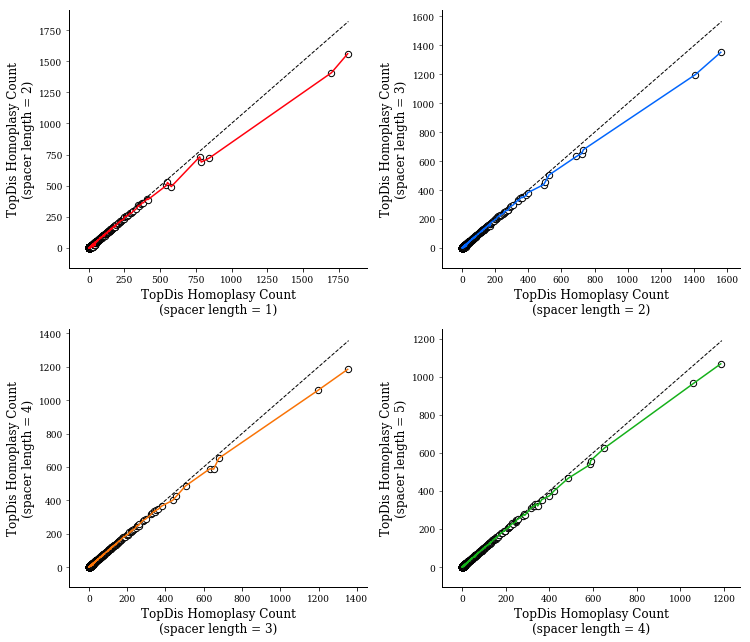

In [84]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])
f_ax3 = fig.add_subplot(spec[1, 0])
f_ax4 = fig.add_subplot(spec[1, 1])

def plot_TopDis(n, color, ax):
    max_homoplasy_count = np.max([np.max(TopDis_homoplasy_DF_dict[str(n)].total) , np.max(TopDis_homoplasy_DF_dict[str(n+1)].total)])
    axis_pad = 5
    
    #plot y=x
    ax.plot([-axis_pad, max_homoplasy_count+axis_pad] , [-axis_pad, max_homoplasy_count+axis_pad] , color = '0.0' , linewidth = 1.0 , linestyle = '--' , alpha = 1.0)
    
    #sort the TopDis(n) homoplasy counts from smallest to largest
    TopDis_homoplasy_total_spacer_n_sorted = TopDis_homoplasy_DF_dict[str(n)].total.sort_values()
    TopDis_homoplasy_total_spacer_n_sorted_indices = TopDis_homoplasy_total_spacer_n_sorted.index
    #sort the TopDis(n+1) homoplasy counts according to the index of the sorted TopDis(n) homoplasy series
    TopDis_homoplasy_total_spacer_n_plus_1_sorted = TopDis_homoplasy_DF_dict[str(n+1)].total[TopDis_homoplasy_total_spacer_n_sorted_indices]
    ax.plot(TopDis_homoplasy_total_spacer_n_sorted , TopDis_homoplasy_total_spacer_n_plus_1_sorted , color = color , linewidth = 1.5 , linestyle = '-' , alpha = 1.0)
    ax.scatter(TopDis_homoplasy_total_spacer_n_sorted , TopDis_homoplasy_total_spacer_n_plus_1_sorted , color = '1.0' , linewidth = 1.0 , edgecolor = 'black', alpha = 1.0, s = 40)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(labelcolor = 'k')
    
    ax.set_xlabel('TopDis Homoplasy Count\n(spacer length = {0})'.format(str(n)) , fontsize = 12 , color = 'k')
    ax.set_ylabel('TopDis Homoplasy Count\n(spacer length = {0})'.format(str(n+1)) , fontsize = 12 , color = 'k')
    #ax.set_title('hSNP count between sampling in Subjects with Treatment Failure' , fontweight = 'bold', fontsize = 12 , color = 'k')
    
plot_TopDis(1, 'xkcd:bright red', f_ax1) #1 & 2
plot_TopDis(2, 'xkcd:bright blue', f_ax2) #2 & 3
plot_TopDis(3, 'xkcd:orange', f_ax3) #3 & 4
plot_TopDis(4, 'xkcd:green', f_ax4) #4 & 5

fig = plt.gcf()
fig.set_size_inches(10.5, 9.0)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/longitudinal_SNP_analysis/SNPs_detected_I2_vs_SNPs_detected_I1.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [85]:
TopDis_homoplasy_DF_dict['1'].sort_values(by = 'total' , ascending = False).head(n = 10)

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
419144,391656,2155168,C,Rv1908c,1279.0,Antibiotic Resistance,katG,G,192.0,490.0,277.0,311.0,345.0,184.0,8.0,7.0,1814.0
162233,150712,761155,C,Rv0667,1348.0,Antibiotic Resistance,rpoB,T,75.0,630.0,191.0,257.0,346.0,189.0,9.0,3.0,1700.0
166633,154766,781687,A,Rv0682,127.0,Antibiotic Resistance,rpsL,G,37.0,529.0,98.0,64.0,54.0,54.0,6.0,2.0,844.0
792952,742888,4247429,A,Rv3795,915.0,Antibiotic Resistance,embB,G,33.0,442.0,64.0,75.0,112.0,60.0,2.0,0.0,788.0
328332,306580,1673425,C,intergenic,NaN,None,None,T,161.0,212.0,63.0,116.0,122.0,95.0,5.0,3.0,777.0
293175,273547,1473246,A,Rvnr01,1400.0,None,None,G,5.0,344.0,31.0,72.0,74.0,52.0,0.0,0.0,578.0
792956,742890,4247431,G,Rv3795,917.0,Antibiotic Resistance,embB,A,18.0,195.0,78.0,92.0,96.0,63.0,5.0,4.0,551.0
2272,1981,7582,A,Rv0006,280.0,Antibiotic Resistance,gyrA,G,10.0,315.0,66.0,75.0,55.0,23.0,0.0,0.0,544.0
725264,679431,3884906,A,Rv3467,942.0,Non-Essential,Rv3467,A,78.0,31.0,0.0,43.0,152.0,109.0,0.0,1.0,414.0
725256,679423,3883626,A,Rv3466,101.0,Non-Essential,Rv3466,G,0.0,126.0,56.0,74.0,149.0,0.0,5.0,0.0,410.0


In [86]:
TopDis_homoplasy_DF_dict['2'].sort_values(by = 'total' , ascending = False).head(n = 10)

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
419144,391656,2155168,C,Rv1908c,1279.0,Antibiotic Resistance,katG,G,171.0,393.0,239.0,278.0,296.0,170.0,6.0,7.0,1560.0
162233,150712,761155,C,Rv0667,1348.0,Antibiotic Resistance,rpoB,T,71.0,466.0,174.0,224.0,295.0,167.0,7.0,3.0,1407.0
328332,306580,1673425,C,intergenic,NaN,None,None,T,142.0,202.0,61.0,111.0,116.0,92.0,5.0,3.0,732.0
166633,154766,781687,A,Rv0682,127.0,Antibiotic Resistance,rpsL,G,34.0,419.0,93.0,63.0,53.0,52.0,6.0,2.0,722.0
792952,742888,4247429,A,Rv3795,915.0,Antibiotic Resistance,embB,G,30.0,361.0,63.0,70.0,107.0,57.0,2.0,0.0,690.0
792956,742890,4247431,G,Rv3795,917.0,Antibiotic Resistance,embB,A,18.0,184.0,74.0,89.0,93.0,60.0,5.0,3.0,526.0
2272,1981,7582,A,Rv0006,280.0,Antibiotic Resistance,gyrA,G,10.0,280.0,63.0,73.0,53.0,23.0,0.0,0.0,502.0
293175,273547,1473246,A,Rvnr01,1400.0,None,None,G,5.0,281.0,30.0,65.0,68.0,44.0,0.0,0.0,493.0
725256,679423,3883626,A,Rv3466,101.0,Non-Essential,Rv3466,G,0.0,118.0,55.0,72.0,146.0,0.0,5.0,0.0,396.0
725264,679431,3884906,A,Rv3467,942.0,Non-Essential,Rv3467,A,74.0,30.0,0.0,43.0,141.0,99.0,0.0,1.0,388.0


In [87]:
TopDis_homoplasy_DF_dict['3'].sort_values(by = 'total' , ascending = False).head(n = 10)

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
419144,391656,2155168,C,Rv1908c,1279.0,Antibiotic Resistance,katG,G,148.0,334.0,207.0,245.0,248.0,157.0,6.0,7.0,1352.0
162233,150712,761155,C,Rv0667,1348.0,Antibiotic Resistance,rpoB,T,68.0,367.0,158.0,194.0,249.0,153.0,6.0,3.0,1198.0
328332,306580,1673425,C,intergenic,NaN,None,None,T,130.0,189.0,59.0,101.0,107.0,85.0,5.0,3.0,679.0
166633,154766,781687,A,Rv0682,127.0,Antibiotic Resistance,rpsL,G,34.0,358.0,89.0,61.0,52.0,50.0,6.0,2.0,652.0
792952,742888,4247429,A,Rv3795,915.0,Antibiotic Resistance,embB,G,30.0,312.0,62.0,68.0,102.0,56.0,2.0,0.0,632.0
792956,742890,4247431,G,Rv3795,917.0,Antibiotic Resistance,embB,A,18.0,176.0,73.0,86.0,87.0,57.0,5.0,3.0,505.0
2272,1981,7582,A,Rv0006,280.0,Antibiotic Resistance,gyrA,G,10.0,245.0,60.0,67.0,51.0,23.0,0.0,0.0,456.0
293175,273547,1473246,A,Rvnr01,1400.0,None,None,G,5.0,241.0,30.0,61.0,62.0,39.0,0.0,0.0,438.0
725256,679423,3883626,A,Rv3466,101.0,Non-Essential,Rv3466,G,0.0,113.0,55.0,67.0,141.0,0.0,5.0,0.0,381.0
725264,679431,3884906,A,Rv3467,942.0,Non-Essential,Rv3467,A,69.0,30.0,0.0,42.0,130.0,91.0,0.0,1.0,363.0


In [88]:
TopDis_homoplasy_DF_dict['4'].sort_values(by = 'total' , ascending = False).head(n = 10)

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
419144,391656,2155168,C,Rv1908c,1279.0,Antibiotic Resistance,katG,G,137.0,282.0,182.0,221.0,211.0,140.0,5.0,7.0,1185.0
162233,150712,761155,C,Rv0667,1348.0,Antibiotic Resistance,rpoB,T,65.0,300.0,143.0,181.0,219.0,143.0,6.0,3.0,1060.0
328332,306580,1673425,C,intergenic,NaN,None,None,T,119.0,180.0,58.0,100.0,104.0,83.0,5.0,3.0,652.0
792952,742888,4247429,A,Rv3795,915.0,Antibiotic Resistance,embB,G,29.0,279.0,60.0,66.0,98.0,55.0,2.0,0.0,589.0
166633,154766,781687,A,Rv0682,127.0,Antibiotic Resistance,rpsL,G,34.0,304.0,82.0,61.0,52.0,48.0,4.0,2.0,587.0
792956,742890,4247431,G,Rv3795,917.0,Antibiotic Resistance,embB,A,18.0,167.0,71.0,84.0,84.0,54.0,5.0,3.0,486.0
2272,1981,7582,A,Rv0006,280.0,Antibiotic Resistance,gyrA,G,10.0,219.0,60.0,63.0,50.0,21.0,0.0,0.0,423.0
293175,273547,1473246,A,Rvnr01,1400.0,None,None,G,5.0,212.0,30.0,59.0,59.0,35.0,0.0,0.0,400.0
725256,679423,3883626,A,Rv3466,101.0,Non-Essential,Rv3466,G,0.0,106.0,52.0,66.0,137.0,0.0,5.0,0.0,366.0
725264,679431,3884906,A,Rv3467,942.0,Non-Essential,Rv3467,A,65.0,30.0,0.0,42.0,124.0,85.0,0.0,1.0,347.0


In [89]:
TopDis_homoplasy_DF_dict['5'].sort_values(by = 'total' , ascending = False).head(n = 10)

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
419144,391656,2155168,C,Rv1908c,1279.0,Antibiotic Resistance,katG,G,127.0,238.0,162.0,203.0,195.0,131.0,5.0,7.0,1068.0
162233,150712,761155,C,Rv0667,1348.0,Antibiotic Resistance,rpoB,T,62.0,265.0,134.0,167.0,195.0,134.0,5.0,3.0,965.0
328332,306580,1673425,C,intergenic,NaN,None,None,T,110.0,171.0,58.0,98.0,102.0,78.0,5.0,3.0,625.0
792952,742888,4247429,A,Rv3795,915.0,Antibiotic Resistance,embB,G,29.0,257.0,58.0,64.0,96.0,53.0,2.0,0.0,559.0
166633,154766,781687,A,Rv0682,127.0,Antibiotic Resistance,rpsL,G,33.0,262.0,79.0,60.0,52.0,47.0,4.0,2.0,539.0
792956,742890,4247431,G,Rv3795,917.0,Antibiotic Resistance,embB,A,18.0,161.0,67.0,84.0,77.0,52.0,4.0,3.0,466.0
2272,1981,7582,A,Rv0006,280.0,Antibiotic Resistance,gyrA,G,10.0,206.0,60.0,59.0,46.0,21.0,0.0,0.0,402.0
293175,273547,1473246,A,Rvnr01,1400.0,None,None,G,5.0,197.0,29.0,57.0,52.0,34.0,0.0,0.0,374.0
725256,679423,3883626,A,Rv3466,101.0,Non-Essential,Rv3466,G,0.0,103.0,51.0,66.0,130.0,0.0,5.0,0.0,355.0
28979,26047,105060,G,Rv0095c,255.0,Non-Essential,Rv0095c,A,16.0,68.0,34.0,54.0,95.0,58.0,4.0,2.0,331.0


In [90]:
TopDis_homoplasy_DF_dict['6'].sort_values(by = 'total' , ascending = False).head(n = 10)

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
419144,391656,2155168,C,Rv1908c,1279.0,Antibiotic Resistance,katG,G,117.0,204.0,142.0,188.0,182.0,120.0,5.0,7.0,965.0
162233,150712,761155,C,Rv0667,1348.0,Antibiotic Resistance,rpoB,T,61.0,236.0,125.0,156.0,179.0,126.0,5.0,3.0,891.0
328332,306580,1673425,C,intergenic,NaN,None,None,T,100.0,169.0,56.0,94.0,97.0,73.0,5.0,3.0,597.0
792952,742888,4247429,A,Rv3795,915.0,Antibiotic Resistance,embB,G,29.0,230.0,56.0,63.0,93.0,52.0,2.0,0.0,525.0
166633,154766,781687,A,Rv0682,127.0,Antibiotic Resistance,rpsL,G,32.0,230.0,78.0,59.0,51.0,47.0,4.0,2.0,503.0
792956,742890,4247431,G,Rv3795,917.0,Antibiotic Resistance,embB,A,18.0,154.0,66.0,79.0,76.0,50.0,4.0,3.0,450.0
2272,1981,7582,A,Rv0006,280.0,Antibiotic Resistance,gyrA,G,10.0,188.0,59.0,58.0,45.0,21.0,0.0,0.0,381.0
293175,273547,1473246,A,Rvnr01,1400.0,None,None,G,5.0,180.0,28.0,54.0,49.0,33.0,0.0,0.0,349.0
725256,679423,3883626,A,Rv3466,101.0,Non-Essential,Rv3466,G,0.0,97.0,50.0,64.0,124.0,0.0,5.0,0.0,340.0
28979,26047,105060,G,Rv0095c,255.0,Non-Essential,Rv0095c,A,15.0,68.0,34.0,53.0,93.0,57.0,4.0,2.0,326.0


####################################################################################################################################################################################

## [4] Compare *homoplasy count* from SNPPar & TopDis

####################################################################################################################################################################################

Replace SNPPar homoplasy DF with DF that had original ordering

In [91]:
SNPPar_homoplasy_DF = SNPPar_homoplasy_DF_orig_ordering

In [92]:
TopDis_homoplasy_DF_dict['1'].head()

,SNP_i,pos,ref,gene_id,gene_pos,gene_category,gene_name,minor,1,2,3,4A,4B,4C,5,6,total
0,0,48,C,Rv0001,47.0,Essential,dnaA,T,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,64,G,Rv0001,63.0,Essential,dnaA,C,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,67,G,Rv0001,66.0,Essential,dnaA,T,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,67,G,Rv0001,66.0,Essential,dnaA,A,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,3,69,C,Rv0001,68.0,Essential,dnaA,T,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [93]:
def plot_SNPPar_v_TopDis_homoplasy_count(spacer_length, color, ax):

    max_homoplasy_count = np.max([np.max(SNPPar_homoplasy_DF.total) , np.max(TopDis_homoplasy_DF_dict[spacer_length].total)])
    axis_pad = 80
    ax.plot([-axis_pad, max_homoplasy_count+axis_pad] , [-axis_pad, max_homoplasy_count+axis_pad] , color = '0.5' , linewidth = 2.0 , linestyle = '--' , alpha = 0.7)
    ax.scatter( SNPPar_homoplasy_DF.total , TopDis_homoplasy_DF_dict[spacer_length].total , color = color , edgecolor = 'white' , linewidth = 0.5 , alpha = 0.6 , s = 36)

    ax.set_xlim([-axis_pad, max_homoplasy_count+axis_pad])
    ax.set_ylim([-axis_pad, max_homoplasy_count+axis_pad])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='y', which='major', labelsize=10.5, labelcolor = 'k', bottom=False)
    ax.tick_params(axis='x', which='major', labelsize=10.5, labelcolor = 'k',left=False)

    ax.set_ylabel('TopDis Homoplasy Score' , fontsize = 11 , color = 'k')
    ax.set_xlabel('SNPPar Homoplasy Score' , fontsize = 11 , color = 'k')
    ax.set_title('Spacer = {0}'.format(spacer_length) , fontsize = 11 , color = 'k', pad = -3)

### Create supplementary Figure

In [94]:
np.shape(SNPPar_homoplasy_DF)

(836901, 20)

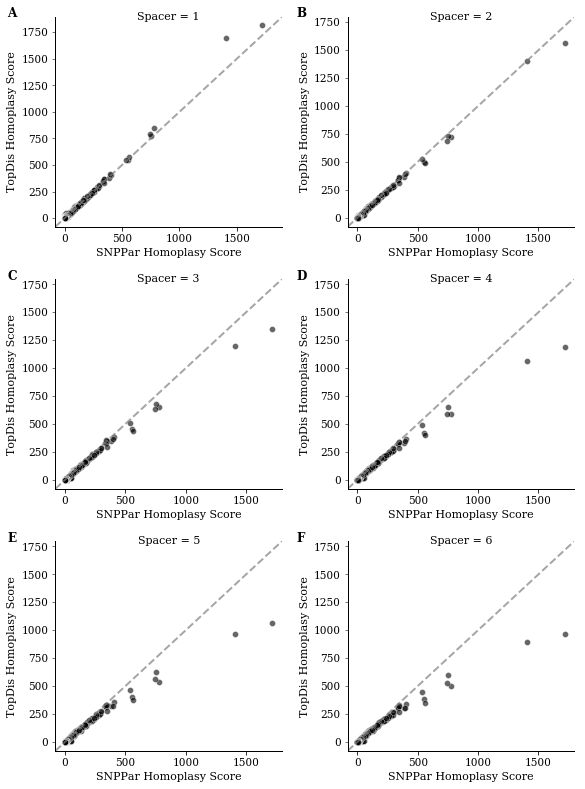

In [106]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
spec.update(wspace=0.29, hspace=0.25) # set the spacing between axes.

f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])
f_ax3 = fig.add_subplot(spec[1, 0])
f_ax4 = fig.add_subplot(spec[1, 1])
f_ax5 = fig.add_subplot(spec[2, 0])
f_ax6 = fig.add_subplot(spec[2, 1])
    
plot_SNPPar_v_TopDis_homoplasy_count('1', 'xkcd:black', f_ax1) #spacer length = 1
plot_SNPPar_v_TopDis_homoplasy_count('2', 'xkcd:black', f_ax2) #spacer length = 2
plot_SNPPar_v_TopDis_homoplasy_count('3', 'xkcd:black', f_ax3) #spacer length = 3
plot_SNPPar_v_TopDis_homoplasy_count('4', 'xkcd:black', f_ax4) #spacer length = 4
plot_SNPPar_v_TopDis_homoplasy_count('5', 'xkcd:black', f_ax5) #spacer length = 5
plot_SNPPar_v_TopDis_homoplasy_count('6', 'xkcd:black', f_ax6) #spacer length = 6

fig.text(0.053, 0.88, 'A', fontsize=12 , fontweight='bold' , color = 'k')
fig.text(0.485, 0.88, 'B', fontsize=12 , fontweight='bold' , color = 'k')

fig.text(0.053, 0.61, 'C', fontsize=12 , fontweight='bold' , color = 'k')
fig.text(0.485, 0.61, 'D', fontsize=12 , fontweight='bold' , color = 'k')

fig.text(0.053, 0.34, 'E', fontsize=12 , fontweight='bold' , color = 'k')
fig.text(0.485, 0.34, 'F', fontsize=12 , fontweight='bold' , color = 'k')

fig = plt.gcf()
fig.set_size_inches(9.3, 13.5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/for publication/SNPPar vs TopDis for SNVs.png'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

## For Dissertation Defense

In [109]:
def plot_SNPPar_v_TopDis_homoplasy_count(spacer_length, color, ax):

    max_homoplasy_count = np.max([np.max(SNPPar_homoplasy_DF.total) , np.max(TopDis_homoplasy_DF_dict[spacer_length].total)])
    axis_pad = 40
    ax.plot([-axis_pad, max_homoplasy_count+axis_pad] , [-axis_pad, max_homoplasy_count+axis_pad] , color = '0.5' , linewidth = 2.0 , linestyle = '--' , alpha = 0.7)
    ax.scatter( SNPPar_homoplasy_DF.total , TopDis_homoplasy_DF_dict[spacer_length].total , color = color , edgecolor = 'white' , linewidth = 0.85 , alpha = 0.65 , s = 47)

    ax.set_xlim([-axis_pad, max_homoplasy_count+axis_pad])
    ax.set_ylim([-axis_pad, max_homoplasy_count+axis_pad])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='y', which='major', labelsize=12, labelcolor = 'k', bottom=False)
    ax.tick_params(axis='x', which='major', labelsize=12, labelcolor = 'k',left=False)

    ax.set_ylabel('TopDis Homoplasy Score' , fontsize = 13 , color = 'k')
    ax.set_xlabel('SNPPar Homoplasy Score' , fontsize = 13 , color = 'k')
    #ax.set_title('Spacer = {0}'.format(spacer_length) , fontsize = 11 , color = 'k', pad = -3)

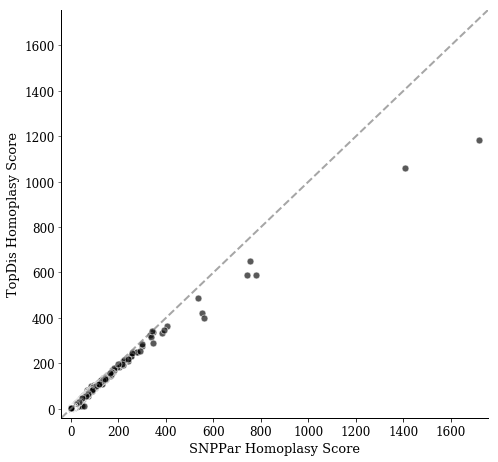

In [110]:
fig , ax = plt.subplots()
    
plot_SNPPar_v_TopDis_homoplasy_count('4', 'xkcd:black', ax) #spacer length = 4

fig = plt.gcf()
fig.set_size_inches(7.0, 6.5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/for publication/A3.3.A.png'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### Reset index! (from mutation keys back to regular range indexing)

In [126]:
SNPPar_homoplasy_DF.reset_index(inplace = True , drop = True)

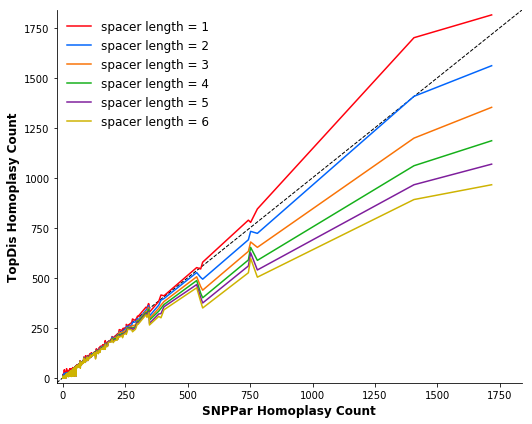

In [127]:
fig , ax = plt.subplots()

max_homoplasy_count = np.max([np.max(SNPPar_homoplasy_DF.total) , np.max(TopDis_homoplasy_DF_dict['1'].total) , np.max(TopDis_homoplasy_DF_dict['2'].total) , np.max(TopDis_homoplasy_DF_dict['3'].total) , np.max(TopDis_homoplasy_DF_dict['4'].total) , np.max(TopDis_homoplasy_DF_dict['5'].total)])
axis_pad = 25

#sort the SNPPar homoplasy counts from smallest to largest
SNPPar_homoplasy_total_sorted = SNPPar_homoplasy_DF.total.sort_values()
SNPPar_homoplasy_total_sorted_indices = SNPPar_homoplasy_total_sorted.index

#sort the TopDis homoplasy counts according to the index of the sorted SNPPar homoplasy series
TopDis_homoplasy_total_spacer_1_sorted = TopDis_homoplasy_DF_dict['1'].total[SNPPar_homoplasy_total_sorted_indices]
TopDis_homoplasy_total_spacer_2_sorted = TopDis_homoplasy_DF_dict['2'].total[SNPPar_homoplasy_total_sorted_indices]
TopDis_homoplasy_total_spacer_3_sorted = TopDis_homoplasy_DF_dict['3'].total[SNPPar_homoplasy_total_sorted_indices]
TopDis_homoplasy_total_spacer_4_sorted = TopDis_homoplasy_DF_dict['4'].total[SNPPar_homoplasy_total_sorted_indices]
TopDis_homoplasy_total_spacer_5_sorted = TopDis_homoplasy_DF_dict['5'].total[SNPPar_homoplasy_total_sorted_indices]
TopDis_homoplasy_total_spacer_6_sorted = TopDis_homoplasy_DF_dict['6'].total[SNPPar_homoplasy_total_sorted_indices]

ax.plot([-axis_pad, max_homoplasy_count+axis_pad] , [-axis_pad, max_homoplasy_count+axis_pad] , color = '0.0' , linewidth = 1.0 , linestyle = '--' , alpha = 1.0)
spacer_1 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_1_sorted , color = 'xkcd:bright red' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 1')
spacer_2 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_2_sorted , color = 'xkcd:bright blue' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 2')
spacer_3 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_3_sorted , color = 'xkcd:orange' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 3')
spacer_4 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_4_sorted , color = 'xkcd:green' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 4')
spacer_5 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_5_sorted , color = 'xkcd:purple' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 5')
spacer_6 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_6_sorted , color = 'xkcd:mustard' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 6')

ax.set_xlim([-axis_pad, max_homoplasy_count+axis_pad])
ax.set_ylim([-axis_pad, max_homoplasy_count+axis_pad])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelcolor = 'k')

ax.set_ylabel('TopDis Homoplasy Count' , fontweight = 'bold', fontsize = 12 , color = 'k')
ax.set_xlabel('SNPPar Homoplasy Count' , fontweight = 'bold', fontsize = 12 , color = 'k')
plt.legend(loc="upper left", frameon=False , fontsize = 12)
#ax.set_title('hSNP count between sampling in Subjects with Treatment Failure' , fontweight = 'bold', fontsize = 12 , color = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 6.0)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/longitudinal_SNP_analysis/SNPs_detected_I2_vs_SNPs_detected_I1.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

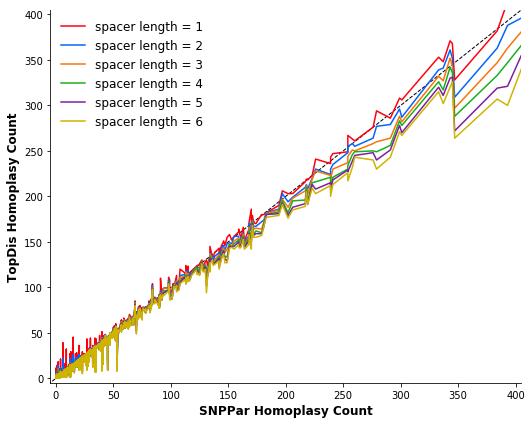

In [128]:
fig , ax = plt.subplots()

max_homoplasy_count = np.max([np.max(SNPPar_homoplasy_DF.total) , np.max(TopDis_homoplasy_DF_dict['1'].total) , np.max(TopDis_homoplasy_DF_dict['2'].total) , np.max(TopDis_homoplasy_DF_dict['3'].total) , np.max(TopDis_homoplasy_DF_dict['4'].total) , np.max(TopDis_homoplasy_DF_dict['5'].total)])
axis_pad = 25

#sort the SNPPar homoplasy counts from smallest to largest
SNPPar_homoplasy_total_sorted = SNPPar_homoplasy_DF.total.sort_values()
SNPPar_homoplasy_total_sorted_indices = SNPPar_homoplasy_total_sorted.index

#sort the TopDis homoplasy counts according to the index of the sorted SNPPar homoplasy series
TopDis_homoplasy_total_spacer_1_sorted = TopDis_homoplasy_DF_dict['1'].total[SNPPar_homoplasy_total_sorted_indices]
TopDis_homoplasy_total_spacer_2_sorted = TopDis_homoplasy_DF_dict['2'].total[SNPPar_homoplasy_total_sorted_indices]
TopDis_homoplasy_total_spacer_3_sorted = TopDis_homoplasy_DF_dict['3'].total[SNPPar_homoplasy_total_sorted_indices]
TopDis_homoplasy_total_spacer_4_sorted = TopDis_homoplasy_DF_dict['4'].total[SNPPar_homoplasy_total_sorted_indices]
TopDis_homoplasy_total_spacer_5_sorted = TopDis_homoplasy_DF_dict['5'].total[SNPPar_homoplasy_total_sorted_indices]
TopDis_homoplasy_total_spacer_6_sorted = TopDis_homoplasy_DF_dict['6'].total[SNPPar_homoplasy_total_sorted_indices]

ax.plot([-axis_pad, max_homoplasy_count+axis_pad] , [-axis_pad, max_homoplasy_count+axis_pad] , color = '0.0' , linewidth = 1.0 , linestyle = '--' , alpha = 1.0)
spacer_1 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_1_sorted , color = 'xkcd:bright red' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 1')
spacer_2 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_2_sorted , color = 'xkcd:bright blue' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 2')
spacer_3 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_3_sorted , color = 'xkcd:orange' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 3')
spacer_4 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_4_sorted , color = 'xkcd:green' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 4')
spacer_5 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_5_sorted , color = 'xkcd:purple' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 5')
spacer_6 = ax.plot(SNPPar_homoplasy_total_sorted , TopDis_homoplasy_total_spacer_6_sorted , color = 'xkcd:mustard' , linewidth = 1.5 , linestyle = '-' , alpha = 1.0, label = 'spacer length = 6')

ax.set_xlim([-5, 405])
ax.set_ylim([-5, 405])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelcolor = 'k')

ax.set_ylabel('TopDis Homoplasy Count' , fontweight = 'bold', fontsize = 12 , color = 'k')
ax.set_xlabel('SNPPar Homoplasy Count' , fontweight = 'bold', fontsize = 12 , color = 'k')
plt.legend(loc="upper left", frameon=False , fontsize = 12)
#ax.set_title('hSNP count between sampling in Subjects with Treatment Failure' , fontweight = 'bold', fontsize = 12 , color = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 6.0)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/longitudinal_SNP_analysis/SNPs_detected_I2_vs_SNPs_detected_I1.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()